In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
# import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [9]:
'''加载数据集'''
new_transactions = pd.read_csv('/home/jerry/GitRepository/大文件数据仓库/CustomerLoyalty/new_merchant_transactions.csv', nrows = 400000)
historical_transactions = pd.read_csv('/home/jerry/GitRepository/大文件数据仓库/CustomerLoyalty/historical_transactions.csv', nrows = 400000)
train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')

In [11]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [12]:
new_transactions.sample(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
223751,Y,C_ID_ed01d2a97f,12,N,1,B,367,M_ID_dfcad3b02b,2,-0.685464,2018-04-13 22:58:14,5.0,5,16
98498,Y,C_ID_4188cca4ed,69,N,1,B,665,M_ID_076cd8a829,1,-0.660040,2018-03-26 15:32:40,1.0,9,3
323319,Y,C_ID_1cf4211b86,274,N,1,B,884,M_ID_94f488a104,1,-0.341643,2018-03-13 18:43:41,1.0,9,27
275599,Y,C_ID_d580088f9a,69,N,1,B,454,M_ID_f546139883,1,-0.721363,2018-03-06 14:31:55,1.0,9,39
351822,Y,C_ID_b5e90331af,205,N,1,B,307,M_ID_3d31624f97,2,-0.536987,2018-04-27 08:00:24,4.0,14,19


In [13]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [14]:
test_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [18]:
train_df.describe()

,feature_1,feature_2,feature_3,target
count,201917.000000,201917.000000,201917.000000,201917.000000
mean,3.105311,1.745410,0.565569,-0.393636
std,1.186160,0.751362,0.495683,3.850500
min,1.000000,1.000000,0.000000,-33.219281
25%,2.000000,1.000000,0.000000,-0.883110
50%,3.000000,2.000000,1.000000,-0.023437
75%,4.000000,2.000000,1.000000,0.765453
max,5.000000,3.000000,1.000000,17.965068


In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


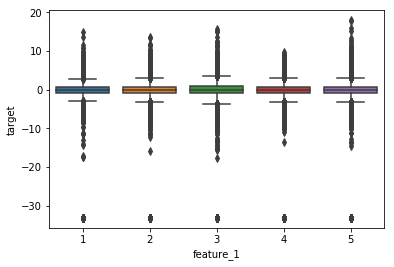

In [21]:
ax = sns.boxplot(x = 'feature_1', y = 'target', data = train_df)

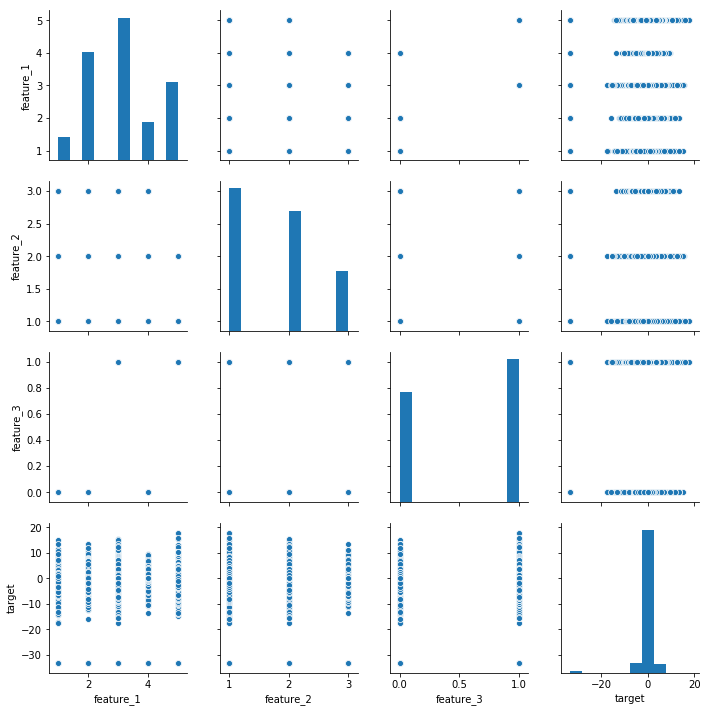

In [22]:
sns.pairplot(data = train_df)

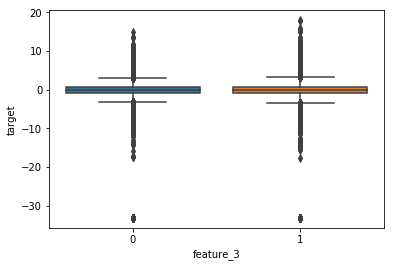

In [26]:
sns.boxplot(x = 'feature_3', y = 'target', data = train_df)

In [29]:
combine = [train_df, test_df]
combine_transactions = [new_transactions, historical_transactions]

In [35]:
'''starting category_1'''
for item in combine_transactions:
    item['category_1'] = item['category_1'].map({'N':0, 'Y':1})

In [36]:
new_transactions.head()
'''finished category_1'''

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,0,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,0,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,0,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,1,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,1,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [39]:
'''starting category_3'''
from collections import Counter
count = Counter(new_transactions['category_3'])
print(count)

Counter({'A': 184924, 'B': 180936, 'C': 24691, nan: 9449})


In [ ]:
for item in combine_transactions:
    item['category_3'] = item['category_3'].map({'A':0, 'B':1, 'C':2}).astype(int)
    item['category_3'] = item['category_3'].fillna(3)


In [45]:
historical_transactions.sample(4)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
251991,Y,C_ID_7244f45cc6,158,0,1,1.0,307,M_ID_dd4dba9556,-6,-0.665449,2017-08-21 09:07:04,1.0,15,19
46514,Y,C_ID_8fc635b8cc,69,0,1,1.0,879,M_ID_00a6ca8a8a,-1,-0.070715,2018-01-11 11:21:57,1.0,9,29
285627,Y,C_ID_b433e5c973,69,0,0,0.0,879,M_ID_00a6ca8a8a,0,-0.732032,2018-02-06 11:17:33,1.0,9,29
195364,Y,C_ID_920535efa0,-1,1,6,2.0,491,M_ID_79692349d6,-7,3.044822,2017-07-13 00:09:03,NaN,-1,3
